In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection  import ValidationCurve
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [4]:
data1 = pd.read_csv('./exchange_ratePrice10000000Lot1000000Sqft10000_ptta.csv')
data1 = data1.drop(columns = ['_25k', '25k_60k','60k_150k', '150k_',
                              'male', 'female', 'sexRatio',
                              'White', 'African', 'Asian', 
                              'Hawaiian', 'Indian', 'Others',
                              'WhiteRatio','MaleMedianAge',
                              'FemaleMedianAge'])
startTime = time.time()
X = data1.iloc[:,:-1].values
y= data1.iloc[:,-1].values
X2 = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test =  train_test_split(X2, y,
                     test_size=0.20)
RF1 = RandomForestRegressor(
                            n_estimators=250,
                            max_depth=9,
                            max_features=36
                            )
RF1.fit(X_train,y_train)
print(time.time() - startTime)

y_train_pred = RF1.predict(X_train)
y_test_pred = RF1.predict(X_test)
print(time.time()-startTime)
print('測試正確率: %.3f' % RF1.score(X_test, y_test))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

76.10750699043274
77.40304327011108
測試正確率: 0.837
MSE train: 39875555358.968, test: 68646393914.996
R^2 train: 0.905, test: 0.837


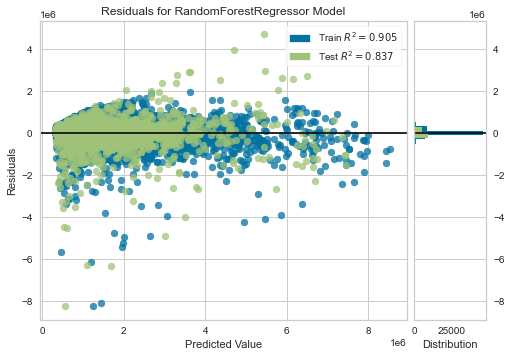

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [6]:
# visualizer繪製殘插圖
visualizer = ResidualsPlot(RF1)
visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test)
visualizer.show()

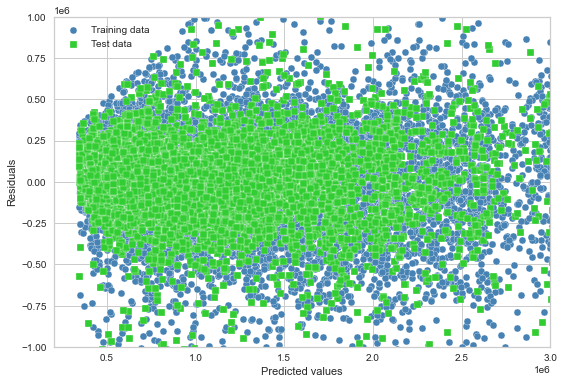

In [7]:
# 第二種殘插圖看喜歡哪個
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([200000, 3000000])
plt.ylim([-1000000,1000000])
plt.tight_layout()

# plt.savefig('demo6_1.png', dpi=300)
plt.show()

In [8]:
cols2=[] # 繪圖用欄位名稱
for i in data1.columns:
    cols2.append(i)
cols2.pop()

'houseprice'

Text(0.5, 1.0, 'RF features importance:')

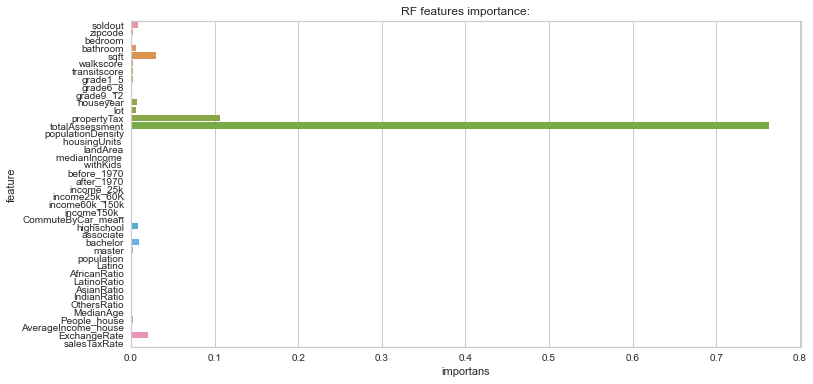

In [9]:
# 重要特徵長條圖
importances = []
for i in RF1.feature_importances_:
    importances.append(i)

feature_dict = {"feature": cols2,"importans":importances}
feature_importance_df =pd.DataFrame(feature_dict)
plt.figure(figsize=(12, 6))
sns.barplot(x="importans", y="feature", data=feature_importance_df)
plt.title('RF features importance:')

<AxesSubplot:>

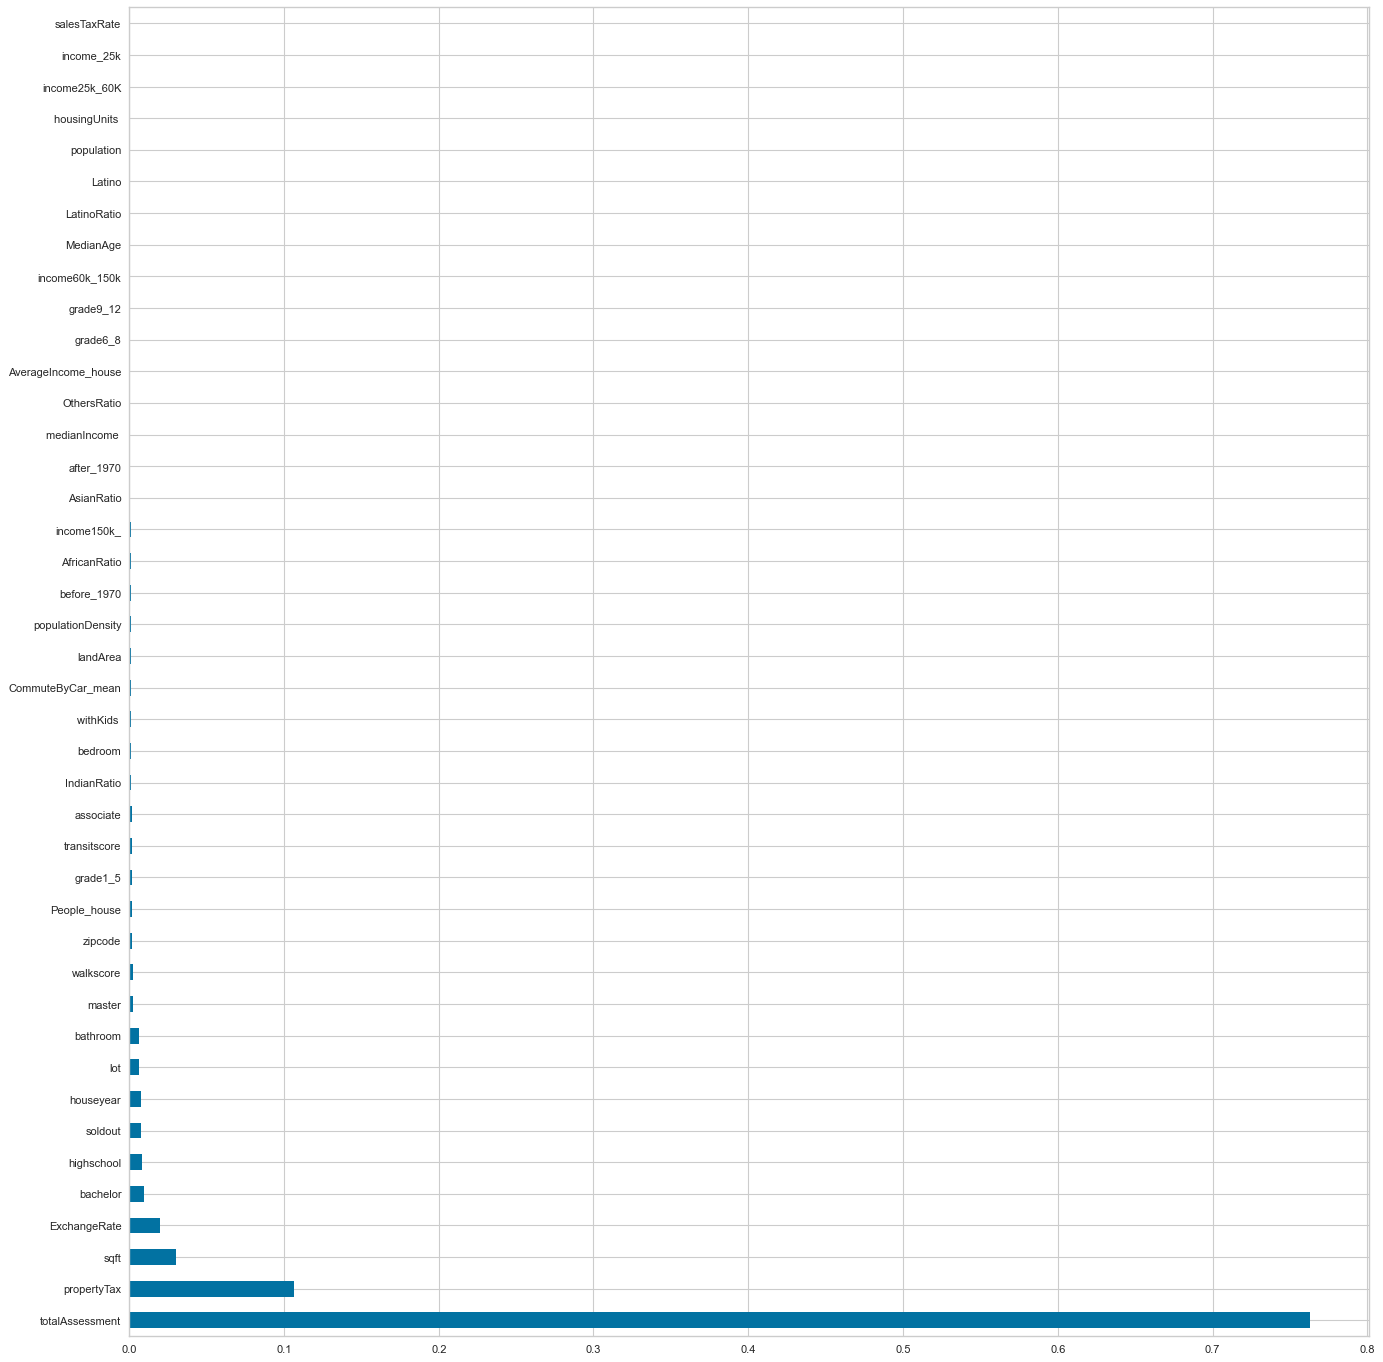

In [10]:
# 兩種圖看喜歡哪一個
plt.figure(num=None, figsize=(20, 22), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(RF1.feature_importances_, index= cols2)
feat_importances.nlargest(56).plot(kind='barh')

In [11]:
# grid_search_cv
data1 = pd.read_csv('./exchange_ratePrice10000000Lot1000000Sqft10000_ptta.csv')
data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
data1 = data1[data1['lot'] < 100000]
data1 = data1.drop(columns = ['_25k', '25k_60k','60k_150k', '150k_',
                              'male', 'female', 'sexRatio',
                              'White', 'African', 'Asian', 'Hawaiian', 'Indian', 'Others',
                              'WhiteRatio','MaleMedianAge',
                              'FemaleMedianAge'])
X = data1.iloc[:,:-1].values
y= data1.iloc[:,-1].values
X2 = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test =  train_test_split(X2, y,
                     test_size=0.20)
RF1 = RandomForestRegressor(
                            n_estimators=750,
                            max_depth=15,
                            max_features=36
                            )
cv_params = {'n_estimators':[750,800,850]}
RF1_cv = GridSearchCV(RF1,param_grid=cv_params, scoring='r2', cv=3, verbose=2, n_jobs=-1)
RF1_cv.fit(X_train,y_train)

# print result
y_train_pred = RF1_cv.predict(X_train)
y_test_pred = RF1_cv.predict(X_test)
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

print(RF1_cv.best_score_)
print(RF1_cv.best_params_)

print("Best score: %0.3f" % RF1_cv.best_score_) # 模型最佳績效
print("Best parameters set:") # 窮舉後的最佳參數
best_parameters = RF1_cv.best_estimator_.get_params()
for param_name in sorted(cv_params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

<ipython-input-11-72ed2aebd154>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  7.4min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  7.7min finished


R^2 train: 0.966, test: 0.896
0.890981044253747
{'n_estimators': 750}
Best score: 0.891
Best parameters set:
	n_estimators: 750


In [17]:
cv = pd.DataFrame(RF1_cv.cv_results_)
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,418.083474,0.402223,2.824448,0.022405,750,{'n_estimators': 750},0.889021,0.887313,0.896608,0.890981,0.004040,1
1,438.942036,1.777763,2.451446,0.125909,800,{'n_estimators': 800},0.888569,0.887267,0.896627,0.890821,0.004140,2
2,455.710212,0.745298,2.316795,0.035849,850,{'n_estimators': 850},0.888601,0.887394,0.896436,0.890810,0.004008,3


In [16]:
# kfold
data1 = pd.read_csv('./exchange_ratePrice10000000Lot1000000Sqft10000_ptta.csv')
data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
data1 = data1[data1['lot'] < 100000]
data1 = data1.drop(columns = ['_25k', '25k_60k','60k_150k', '150k_',
                              'male', 'female', 'sexRatio',
                              'White', 'African', 'Asian', 
                              'Hawaiian', 'Indian', 'Others',
                              'WhiteRatio','MaleMedianAge',
                              'FemaleMedianAge'])
data1['zipcode'] = data1['zipcode'].astype(str)
data1['zipcode'] = data1['zipcode'].astype('category')
X = data1.iloc[:,:-1].values
y= data1.iloc[:,-1].values
X_train, X_test, y_train, y_test =  train_test_split(X, y,
                     test_size=0.20)
RF1 = RandomForestRegressor(
                            n_estimators=750,
                            max_depth=15,
                            max_features=36
                            )
pipe_lr = make_pipeline(StandardScaler(),
                        RF1)
kfold = StratifiedKFold(n_splits=6).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Acc: %.3f' % (k+1,score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

<ipython-input-16-7fa78aeeb431>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
C:\Users\Student\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(("The least populated class in y has only %d"


Fold:  1, Acc: 0.889
Fold:  2, Acc: 0.891
Fold:  3, Acc: 0.894
Fold:  4, Acc: 0.891
Fold:  5, Acc: 0.886
Fold:  6, Acc: 0.899

CV accuracy: 0.891 +/- 0.004
